In [2]:
import pandas as pd

excel_file = pd.ExcelFile('jobs.xlsx')
all = []

# for each sheet in the workbook
for sheet in excel_file.sheet_names:
    # read the sheet into a dataframe
    df = pd.read_excel(excel_file, sheet_name=sheet)
    # export the sheet to csv
    df.to_csv('jobs.csv', index=False)
    # convert the dataframe to a list of dictionaries
    json_list = df.to_dict(orient='records')
    
    # add the sheet name to each dictionary
    for item in json_list:
        item['region'] = sheet
        for key, value in item.items():
            if pd.isna(value):
                item[key] = "None"
    all.extend(json_list)


# export the list of dictionaries to a json file
import json 
with open('jobs.json', 'w') as f:
    json.dump(all, f, indent=4)

In [3]:
# Find all hospitals
hospitals = set()
for job in all:
    for i in range(1, 7):
        site = job.get(f'Placement {i}: Site')
        if site and site != "None" and site.strip() != "":
            hospitals.add(site)

with open('hospitals.txt', 'w') as f:
    for hospital in sorted(hospitals):
        f.write(hospital + '\n')
        

In [ ]:
# import requests
# import time
# import json

# dotenv.load()
# API_KEY = dotenv.get("GOOGLE_MAPS_API_KEY")


# def find_place(name):
#     url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json"
#     params = {
#         "input": name + ", Scotland, UK",
#         "inputtype": "textquery",
#         "fields": "place_id",
#         "key": API_KEY
#     }
#     res = requests.get(url, params=params).json()
#     if res["candidates"]:
#         return res["candidates"][0]["place_id"]
#     return None

# def get_place_details(place_id):
#     url = "https://maps.googleapis.com/maps/api/place/details/json"
#     params = {
#         "place_id": place_id,
#         "fields": "name,geometry,website,formatted_address,formatted_phone_number",
#         "key": API_KEY
#     }
#     res = requests.get(url, params=params).json()
#     if res["status"] == "OK":
#         return res["result"]
#     return None

# with open("hospitals.txt") as f:
#     hospitals = [line.strip() for line in f if line.strip()]

# all_data = []

# for hospital in hospitals:
#     place_id = find_place(hospital)
#     if place_id:
#         details = get_place_details(place_id)
#         if details:
#             all_data.append({
#                 "name": details.get("name"),
#                 "lat": details["geometry"]["location"]["lat"],
#                 "lng": details["geometry"]["location"]["lng"],
#                 "website": details.get("website"),
#                 "address": details.get("formatted_address"),
#                 "phone": details.get("formatted_phone_number"),
#                 "place_id": place_id
#             })
#     time.sleep(0.2)

# with open("hospitals_scotland_full.json", "w") as f:
#     json.dump(all_data, f, indent=2)

# print("Done.")

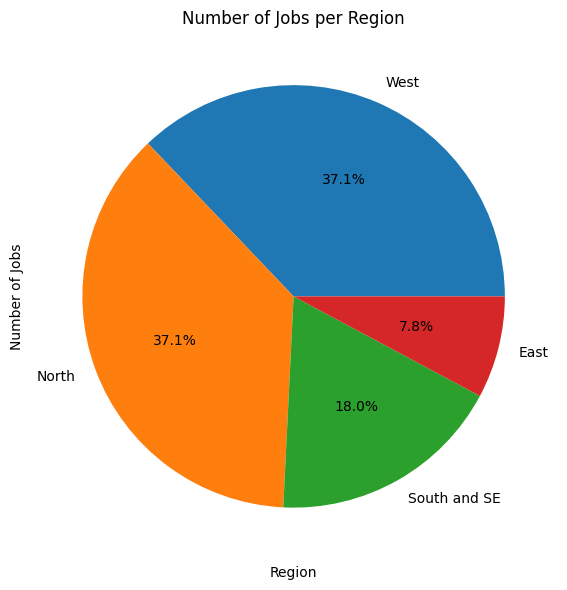

In [ ]:
# plot number of jobs per region pie chart


import matplotlib.pyplot as plt

# Assuming 'jobs' is a DataFrame with a 'region' column
# all array to DataFrame
jobs = pd.DataFrame(all)
region_counts = jobs['region'].value_counts()

plt.figure(figsize=(10, 6))
region_counts.plot(kind='pie', autopct='%3.1f%%')
plt.title('Number of Jobs per Region')
plt.xlabel('Region')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  

In [ ]:
# Nunmber of hopitals

placements = set()
for job in all:
    for i in range(1, 7):
        site = job.get(f'Placement {i}: Site')
        if site and site != "None" and site.strip() != "":
            placements.add(site)
print(f"Number of unique hospitals: {len(placements)}")

Number of unique placements: 199


In [ ]:
# top 20 most common placements
from collections import Counter
placement_counts = Counter()
for job in all:
    for i in range(1, 7):
        site = job.get(f'Placement {i}: Site')
        if site and site != "None" and site.strip() != "":
            placement_counts[site] += 1

top_20 = placement_counts.most_common(20)

print("Top 20 hospitals by number of placements:")
for site, count in top_20:
    print(f"{site}: {count} placements")

Top 20 most common placements:
Queen Elizabeth University Hospital: 918 placements
Glasgow Royal Infirmary: 828 placements
Ninewells Hospital: 575 placements
Aberdeen Royal Infirmary: 567 placements
Forth Valley Royal Hospital: 474 placements
University Hospital Wishaw: 454 placements
University Hospital Crosshouse: 398 placements
Dumfries and Galloway Royal Infirmary: 360 placements
University Hospital Monklands: 312 placements
Royal Alexandra Hospital: 288 placements
Royal Infirmary of Edinburgh at Little France: 279 placements
University Hospital Hairmyres: 278 placements
Raigmore Hospital: 231 placements
Victoria Hospital: 210 placements
University Hospital Ayr: 199 placements
Western General Hospital: 162 placements
St John's Hospital: 126 placements
NHS Lanarkshire: 112 placements
Royal Hospital for Children Glasgow: 108 placements
Inverclyde Royal Hospital: 102 placements


In [ ]:
# bar gragh of top 20 placements
sites, counts = zip(*top_20)
plt.figure(figsize=(12, 8))
plt.barh(sites, counts)
plt.xlabel('Number of Placements')
plt.title('Top 20 Hospitals by Number of Placements')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest at the top
plt.tight_layout()
plt.show()

In [15]:
# Most common specialties
specialty_counts = Counter()
for job in all:
    for i in range(1, 7):
        specialty = job.get(f'Placement {i}: Specialty')
        if specialty and specialty != "None" and specialty.strip() != "":
            specialty_counts[specialty] += 1

print("Top 20 specialties by number of placements:")
for specialty, count in specialty_counts.most_common(20):
    print(f"{specialty}: {count} placements")

Top 20 specialties by number of placements:
General (Internal) Medicine: 1889 placements
General Surgery: 1539 placements
General Practice: 704 placements
Geriatric Medicine: 555 placements
Trauma and Orthopaedic Surgery: 468 placements
Acute Internal Medicine: 421 placements
Emergency Medicine: 414 placements
General Psychiatry: 370 placements
Paediatrics: 298 placements
Obstetrics and Gynaecology: 289 placements
Intensive Care Medicine: 132 placements
Respiratory Medicine: 132 placements
Cardiology: 102 placements
Renal Medicine: 96 placements
Gastroenterology: 90 placements
Urology: 72 placements
Paediatric Surgery: 68 placements
Plastic Surgery: 63 placements
Anaesthetics: 63 placements
Neurosurgery: 59 placements
